# CC5215: Privacidad de Datos

## Laboratorio 10

Integrantes:

- Francisco Gutiérrez Albornoz

In [1]:
# Load the data and libraries
import pandas as pd
import numpy as np
import random
from scipy import stats
import matplotlib.pyplot as plt


def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def gaussian_mech_vec(vec, sensitivity, epsilon, delta):
    return [v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)
            for v in vec]

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

adult = pd.read_csv('https://users.dcc.uchile.cl/~mtoro/cursos/cc5215/adult_with_pii.csv')

## Preamble

In this lab we are going to experiment with more advanced variants of differential privacy. These advanced variants are based on specific statistics concepts and as we will see, they will allow us to compose private results with tighter bounds. Finally, we will implement the noisy gradient descent algorithm seen in class, but with different variants of DP.

## Question 1 (4 points)

Look at the two graphs:

- What information is presented in each plot?
- What can you say about sequential composition for $\epsilon$-DP? what about $(\epsilon, \delta)$-DP?

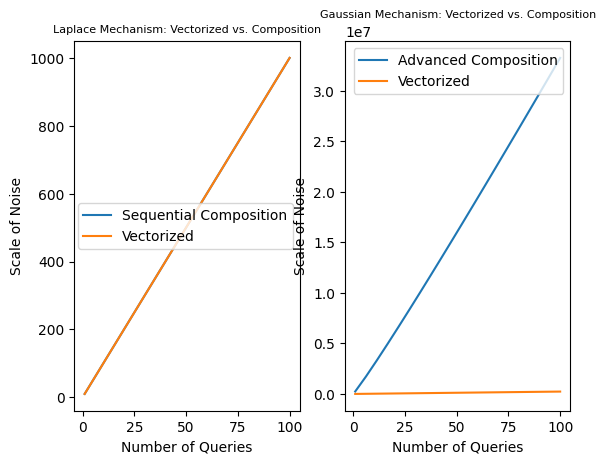

In [2]:
ks = np.linspace(1, 100, 20)


## (epsilon)

epsilon = .1

plt.subplot(1, 2, 1)

# L1 sensitivity of each query: 1
# noise per query: 1/epsilon
# number of queries: k
noises_seq_eps = [k*(1/epsilon) for k in ks]
plt.plot(ks, noises_seq_eps, label='Sequential Composition')

# number of queries: 1
# L1 sensitivity of each query: k
# noise per query: k / epsilon
noises_L1_eps = [1*(k/epsilon) for k in ks]
plt.plot(ks, noises_L1_eps, label='Vectorized')
plt.title('Laplace Mechanism: Vectorized vs. Composition', {
    'fontsize': 8
})
plt.xlabel('Number of Queries')
plt.ylabel('Scale of Noise')
plt.legend();

## (epsilon, delta)

epsilon = .1
delta = 1e-5

plt.subplot(1, 2, 2)

# L2 sensitivity of each query: 1
# number of queries: k
noises_seq_epsdel = [16*k*np.log((2.5*k)/delta)*np.log(2/delta)/(epsilon**2) for k in ks]
plt.plot(ks, noises_seq_epsdel, label='Advanced Composition')

# number of queries: 1
# L2 sensitivity of each query: sqrt(k)
noises_L1_epsdel = [2*k*np.log(1.25/delta)/(epsilon**2) for k in ks]
plt.title('Gaussian Mechanism: Vectorized vs. Composition', {
    'fontsize': 8,
})
plt.xlabel('Number of Queries')
plt.ylabel('Scale of Noise')
plt.plot(ks, noises_L1_epsdel, label='Vectorized')
plt.legend();

- Se muestra cómo afecta al ruido el número de consultas. En la imagen de la izquierda, se compara una composición secuencial con consultas vectorizadas y se aprecia que el comportamiento es similar. En cambio, en la figura de la derecha se compara advance composition con consulta vectorizada si observa que en está última el ruido crece lentamente. 
- En una composición secuencial $\epsilon$-DP el costo total aumenta linealmente con el número de consultas. En cambio para una consulta $(\epsilon,\delta)$-DP, el costo de privacidad crece más lentamente (tal como vimos en la clase 9 es proporcial a la raíz de la cantidad de consultas) y como se grafica el ruido (~$1/(k\epsilon)$), el resultado es lo contrario teniendo un mayor crecimiento en el gráfico. Esto último tiene como consecuencia que al contestar la misma cantidad de consultas se tiene una menor pérdida en la privacidad.

## Improving sequential composition

> Wouldn't you like a better sequential composition? 🤔

In statistics, a [divergence](https://en.wikipedia.org/wiki/Divergence_(statistics)) is a way of measuring the distance between two probability distributions - which is exactly what we want to do for differential privacy. The *max divergence* between two probability distributions $Y$ and $Z$ is defined to be:

$$
D_\infty(Y, Z) = \max_{S \subseteq \mathsf{Supp}(Y)}\Big(\log \frac{Pr[Y \in S]}{Pr[Z \in S]}\Big)
$$

One nice thing about max divergence is that the definition of differential privacy can be easily recovered. In fact, $F$ satisfies $\epsilon$-DP if:

$$
D_\infty(F(x), F(x')) \leq \epsilon
$$

Another interesting definition of a divergence is the [Rényi divergence](https://en.wikipedia.org/wiki/R%C3%A9nyi_entropy#R%C3%A9nyi_divergence) which, like max divergence, allows us to recover the definition of differential privacy. The Rényi divergence of order $\alpha$ between probability distributions $P$ and $Q$ is defined as (where $P(x)$ and $Q(x)$ denote the probability density of $P$ and $Q$ at point $x$, respectively):

$$
D_\alpha(P, Q) = \frac{1}{\alpha - 1}\log E_{x \sim Q}\Big(\frac{P(x)}{Q(x)}\Big)^\alpha
$$

If we set $\alpha = \infty$, we immediately recover the definition of $\epsilon$-DP. But what if we set $\alpha$ to something else?

In 2017, Ilya Mironov proposed [Rényi differential privacy (RDP)](https://arxiv.org/abs/1702.07476). A randomized mechanism $F$ satisfies $(\alpha, \epsilon_r)$-RDP if, for all neighboring datasets $x$ and $x'$: $^1$

$$
D_\alpha(F(x), F(x')) \leq \epsilon_r
$$

A key property of Rényi differential privacy is that a mechanism which satisfies RDP also satisfies $(\epsilon, \delta)$-differential privacy. Specifically, if $F$ satisfies $(\alpha, \epsilon_r)$-RDP, then for $\delta > 0$, $F$ satisfies $(\epsilon, \delta)$-differential privacy for $\epsilon = \epsilon_r + \frac{\log(1 / \delta)}{\alpha - 1}$. The analyst is free to pick any value of $\delta$; a meaningful value (e.g. $\delta \leq \frac{1}{n^2}$) should be picked in practice.

A basic mechanism for achieving RDP is the Gaussian mechanism. Specifically, for a function $f : \mathcal{D} \to \mathbb{R}^k$ with $L2$ sensitivity of $\Delta f$, the following mechanism satisfies $(\alpha, \epsilon_r)$-RDP:

$$
F(x) = f(x) + \mathcal{N}(\sigma^2)\text{ where }\sigma^2 = \frac{\Delta f^2 \alpha}{2\epsilon_r}
$$

$^1$: We use $\epsilon_r$ to differentiate it from the parameter of regular $\epsilon$-DP.

## Question 2 (4 points)

Implement the gaussian mechanism for Rényi DP:

*Hint*: Use `np.random.normal(scale=std, size=n)` with `std` as the standard deviation and `n` the number of sampless to generate.

In [3]:
def gaussian_mech_RDP_vec(vec, sensitivity, alpha, epsilon_r):
    '''Adds gaussian noice to the vector considering RDP.

    Args:
      vec: numpy array of values to which noise will be added.
      sensitivity: L2 sensitivity of the query.
      alpha: RDP parameter.
      epsilon_r: privacy parameter for RDP.

    Returns:
      The numpy array with the added Gaussian noise.
    '''
    std = np.sqrt((sensitivity ** 2 * alpha) / (2 * epsilon_r))
    noise = np.random.normal(scale=std, size=len(vec))
    return np.array(vec) + noise

## Implementing noisy gradient descent with Rényi

The following code blocks include utility functions and definitions:

In [4]:
# Load data files
import urllib.request
import io

url_x = 'https://users.dcc.uchile.cl/~mtoro/cursos/cc5215/adult_processed_x.npy'
url_y = 'https://users.dcc.uchile.cl/~mtoro/cursos/cc5215/adult_processed_y.npy'

with urllib.request.urlopen(url_x) as url:
    f = io.BytesIO(url.read())
X = np.load(f)

with urllib.request.urlopen(url_y) as url:
    f = io.BytesIO(url.read())
y = np.load(f)

In [5]:
# Split data into training and test sets
training_size = int(X.shape[0] * 0.8)

X_train = X[:training_size]
X_test = X[training_size:]

y_train = y[:training_size]
y_test = y[training_size:]

print('Train and test set sizes:', len(y_train), len(y_test))

Train and test set sizes: 36176 9044


In [6]:
##
## Functions seen in class
##

# The loss function measures how good our model is. The training goal is to minimize the loss.
# This is the logistic loss function.
def loss(theta, xi, yi):
    exponent = - yi * (xi.dot(theta))
    return np.log(1 + np.exp(exponent))

# This is the gradient of the logistic loss
# The gradient is a vector that indicates the rate of change of the loss in each direction
def gradient(theta, xi, yi):
    exponent = yi * (xi.dot(theta))
    return - (yi*xi) / (1+np.exp(exponent))

def avg_grad(theta, X, y):
    grads = [gradient(theta, xi, yi) for xi, yi in zip(X, y)]
    return np.mean(grads, axis=0)

# Prediction: take a model (theta) and a single example (xi) and return its predicted label
def predict(xi, theta, bias=0):
    label = np.sign(xi @ theta + bias)
    return label

def accuracy(theta):
    return np.sum(predict(X_test, theta) == y_test)/X_test.shape[0]

# L2 Clipping
def L2_clip(v, b):
    norm = np.linalg.norm(v, ord=2)

    if norm > b:
        return b * (v / norm)
    else:
        return v

def gradient_sum(theta, X, y, b):
    gradients = [L2_clip(gradient(theta, x_i, y_i), b) for x_i, y_i in zip(X,y)]

    # sum query
    # L2 sensitivity is b (by clipping performed above)
    return np.sum(gradients, axis=0)


## Composition of RDP

If
- $F_1$ satisfies $(\alpha, \epsilon_{r1})$-RDP, and
- $F_2$ satisfies $(\alpha, \epsilon_{r2})$-RDP.
- Then, their composition satisfies $(\alpha, \epsilon_{r1} + \epsilon_{r2})$-RDP.

## Question 3 (10 points)

Implement a version of noisy gradient that uses Rényi Differential Privacy. The total privacy cost of `noisy_gradient_descent_RDP` must be of $(\alpha, \epsilon_r)$.

In [ ]:
def noisy_gradient_descent_RDP(iterations, alpha, epsilon_r):
    sensitivity = 5

    theta = np.zeros(X_train.shape[1])
    epsilon_i = epsilon_r / iterations

    for _ in range(iterations):
        grad = gradient_sum(theta, X_train, y_train, sensitivity)
        grad_noisy = gaussian_mech_RDP_vec(grad, sensitivity=sensitivity, alpha=alpha, epsilon_r=epsilon_i)
        theta = theta - grad_noisy

    return theta

In [8]:
test_acc = accuracy(noisy_gradient_descent_RDP(10, 100, 1))
assert (test_acc > .7) and (test_acc < .9)

C:\Users\franc\AppData\Local\Temp\ipykernel_17452\3998788756.py:15: RuntimeWarning: overflow encountered in exp
  return - (yi*xi) / (1+np.exp(exponent))


## Question 4 (6 points)

- Argument, in terms of the equivalence between Rényi-DP and $(\epsilon, \delta)$-DP, how an $\epsilon$-DP laplace mechanism can be sequentially combined with a Rényi-DP guassian mechanism.
- Explain why the total cost of your implementation of `noisy_gradient_descent_RDP` is $(\alpha, \epsilon_r)$-RDP.

**Respuesta**
- Se pueden utilizar ambos mecanismos con los mismos parámetros. En el caso del mecanismo laplaciano solo es $\epsilon$-DP pero el mecanismo gaussiano con Rényi-DP puede tener una conversión en sus parámetros $\epsilon = \epsilon_r + \frac{\log(1 / \delta)}{\alpha - 1}$. Luego de esta conversión se pueden usar secuencialmente.
- Como se mencionó al hacer composición secuencial se cumple $(\alpha, \epsilon_{r1} + \epsilon_{r2})$-RDP, entonces se divide el epsilon total en la cantidad de iteraciones y como se suma, da como resultado el epsilon total.

## Implementing noisy gradient descent with Zero-Concentrated Differential Privacy

In concurrent work to Ilya, in 2016, Mark Bun and Thomas Steinke proposed [zero-concentrated differential privacy (zCDP)](https://arxiv.org/abs/1605.02065). Similar to RDP, zCDP is defined in terms of the Rényi divergence, but it includes only a single privacy parameter ($\rho$). A randomized mechanism $F$ satisfies $\rho$-zCDP if for all neighboring datasets $x$ and $x'$, and all $\alpha \in (0, \infty)$:

$$
D_\alpha(F(x), F(x')) \leq \rho \alpha
$$

This presents a stronger guarantee than RDP, because it restricts Rényi divergence in many orders. However, the bound becomes more relaxed as $\alpha$ grows.

Zero-concentrated DP can also be converted to $(\epsilon, \delta)$-DP: if $F$ satisfies $\rho$-zCDP, then for any $\delta > 0$, $F$ satisfies $(\epsilon, \delta)$-DP for $\epsilon = \rho + 2 \sqrt{\rho \log(1 / \delta)}$.

zCDP is also similar to RDP in that the Gaussian mechanism can be used as a basic mechanism. Specifically, for a function $f : \mathcal{D} \to \mathbb{R}^k$ with $L2$ sensitivity of $\Delta f$, the following mechanism satisfies $(\alpha, \epsilon_r)$-RDP:

$$
F(x) = f(x) + \mathcal{N}(\sigma^2)\text{ where }\sigma^2 = \frac{\Delta f^2}{2\rho}
$$

## Question 5 (2 points)

Implement the guassian mechanism for zCDP:

In [13]:
def gaussian_mech_zCDP_vec(vec, sensitivity, rho):
    '''Adds gaussian noice to the vector considering zCDP.

    Args:
      vec: numpy array of values to which noise will be added.
      sensitivity: L2 sensitivity of the query.
      rho: privacy parameter for zCDP.

    Returns:
        The numpy array with the added Gaussian noise.
    '''
    std = np.sqrt((sensitivity ** 2) / (2 * rho))
    noise = np.random.normal(scale=std, size=len(vec))
    return np.array(vec) + noise

### Composition of zCDP

If

- $F_1$ satisfies $\rho_1$-zCDP, and
- $F_2$ satisfies $\rho_2$-zCDP.
- Then, their composition satisfies $(\rho_1 + \rho_2)$-zCDP

## Question 6 (6 points)

Implement a version of noisy gradient descent using zCDP. Your solution should have a total cost of $\rho$-zCDP.

In [14]:
def noisy_gradient_descent_zCDP(iterations, rho):
    sensitivity = 5

    d = X_train.shape[1]
    theta = np.zeros(d)
    rho_i = rho / iterations
    for _ in range(iterations):
        grad = gradient_sum(theta, X_train, y_train, sensitivity)
        grad_noisy = gaussian_mech_zCDP_vec(grad, sensitivity=sensitivity, rho=rho_i)
        theta = theta - grad_noisy

    return theta

In [15]:
test_acc = accuracy(noisy_gradient_descent_zCDP(10, 1))
assert (test_acc > .7) and (test_acc < .9)

C:\Users\franc\AppData\Local\Temp\ipykernel_17452\3998788756.py:15: RuntimeWarning: overflow encountered in exp
  return - (yi*xi) / (1+np.exp(exponent))


## Question 7 (8 points)

- Argument, in terms of the equivalence between zCDP and $(\epsilon, \delta)$-DP, how an $\epsilon$-DP laplace mechanism can be sequentially combined with a $\rho$-zCDP guassian mechanism. What is different with respect to your previous reasoning when working with RDP?
- Explain why the total cost of your implementation of `noisy_gradient_descent_zCDP` is $\rho$-RDP.

- De la misma forma que se explicó anteriormente, se puede realizar una conversión en los parámetros para que puedan ser combinados secuencialmente. Para este caso habría que utilizar $\epsilon = \rho + 2 \sqrt{\rho \log(1 / \delta)}$ para cualquier $\delta>0$.
- Se puede utilizar la propiedad anteriormente mencionada, $(\rho_1 + \rho_2)$-zCDP, con esto se divide el total a utilizar por la cantidad de iteraciones y luego se suman obtiendo el total.

## Question 8 (12 points)

We are going to explore how the different variants behave in terms of the privacy cost $\epsilon$, when the amount of noise ($\sigma$), the sensitivity ($\Delta f$ or $s$) and $\delta$ have been **fixed**. For doing so, implement the functions below that calculate the sequentially composed privacy cost for each variant.

Notice that for RDP, you will have to find a good value for $\alpha$. Explore values between 1 and 100.

_Hint_: Calculate first the corresponding privacy parameter for one query in terms of the parameters you have. Then, calculate the value of the sequentially composed $\epsilon$ in the $(\epsilon, \delta)$ world.

_Hint 2_: For the advance composition remember that the scale of noise for the gaussian distribution is: $\sigma^2 = \frac{2 \Delta f^2 \log (1.25 / \delta)}{\epsilon^2}$ and that the advance composition states that the total cost for k $(\epsilon,\delta)$ mechanisms is: $\epsilon' = 2\epsilon \sqrt{2k\log{(1 / \delta)}}$.

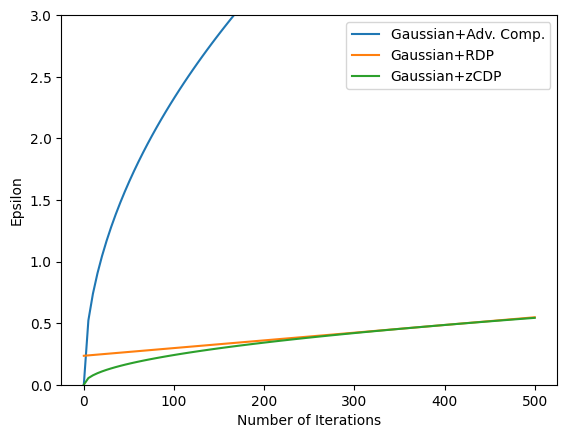

In [28]:
# Fix sigma and delta
sigma = 200.0
delta = 1e-5
sensitivity = 1

# iterations
ks = np.linspace(0, 500, 100)

# Advance composition
def seq_eps_gauss_adv(iterations, sensitivity, sigma, delta):
    eps0 = np.sqrt(2 * (sensitivity ** 2) * np.log(1.25 / delta)) / sigma
    eps_total = 2 * eps0 * np.sqrt(2 * iterations * np.log(1 / delta))
    return eps_total

# Renyi DP
# You have to find an appropiate value for alpha
alpha = 50
def seq_eps_gauss_rdp(iterations, sensitivity, sigma, alpha, delta):
    epsilon_r0 = alpha * (sensitivity ** 2) / (2 * sigma ** 2)
    epsilon_r_total = iterations * epsilon_r0
    eps_total = epsilon_r_total + np.log(1 / delta) / (alpha - 1)
    return eps_total

# Zero Concentrated DP
def seq_eps_gauss_zcdp(iterations, sensitivity, sigma, delta):
    rho0 = (sensitivity ** 2) / (2 * sigma ** 2)
    rho_total = iterations * rho0
    eps_total = rho_total + 2 * np.sqrt(rho_total * np.log(1 / delta))
    return eps_total

ys_gauss_adv = [seq_eps_gauss_adv(k, sensitivity, sigma, delta) for k in ks]
ys_gauss_rdp = [seq_eps_gauss_rdp(k, sensitivity, sigma, alpha, delta) for k in ks]
ys_gauss_zcdp = [seq_eps_gauss_zcdp(k, sensitivity, sigma, delta) for k in ks]

plt.plot(ks, ys_gauss_adv, label="Gaussian+Adv. Comp.")
plt.plot(ks, ys_gauss_rdp, label="Gaussian+RDP")
plt.plot(ks, ys_gauss_zcdp, label="Gaussian+zCDP")

plt.xlabel('Number of Iterations')
plt.ylabel('Epsilon')
plt.ylim(0, 3.0)


plt.legend()
plt.show();

## Question 9 (8 points)

- What is a good value for $\alpha$ and why?
- Does running the above code many times in order to find a good $\alpha$ violates privacy? Why or why not?
- What information is clear about the privacy cost behavior between the different variants?
- How do RDP and zCDP behave in terms of the number of iterations?

- Un buen valor de $\alpha$ no puede ser ni muy chico mi muy grande para que ninguna contribución a la privacidad sea mucho mayor que la otra ($ \displaystyle \frac{\alpha \cdot s^2}{2 \cdot \sigma^2}$ comparado con $ \displaystyle \frac{log(1 / \delta)}{\alpha - 1})$. El valor utilizado fue de 50 que se encuentra entre los valores 10 y 100 que fueron los recomendados.
- No, ya que solo se calculan los parámetros y no se toman en cuenta los datos.
- $\epsilon$ aumenta con el número de iteraciones en todos los casos pero para RDP y zCDP es mucho más controlado el crecimiento comparado con adv composition. 
- RDP tiene un crecimiento lineal en el número de iteraciones y zCDP más similar a un crecimiento logarítmico.